***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

DONE loading MixUp Data generator
DONE loading MixUp Data generator


# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\GitHub Repo\HDeep_CapsNet\code\Training_and_Analysis\3_FMNIST
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "2" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  2
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Import Dataset : FMNIST

In [4]:
dataset = datasets.F_MNIST(version = 'ALL') # importing CIFAR10 Dataset

Fashion-MNIST dataset: Training have 60,000 samples and testing have 10,000 samples


# Parameters

In [5]:
train_params = {"n_epochs" : 100,
                "batch_size": 512,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [6]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [7]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [8]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [9]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 16
    SCap_c_dims = 16

    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]
    reshape= keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims), PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshape)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_f_dims, 
                        name="s_caps_medium")(s_caps_f)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [10]:
model = get_compiled_model()

## log directory

In [11]:
directory = sysenv.log_dir('HD_CapsNet/WO_C_loss')

FOLDER CREATED =  ./logs/HD_CapsNet/WO_C_loss_inc_batch


In [12]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 28, 28, 64)   640         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 28, 28, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 6)           0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 6)           0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 2)            0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 2)           0           ['input_yc[0][0]']               
 )        

 da)                                                                                              
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 10)           0           ['tf.math.multiply_8[0][0]',     
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum_1[0][0]']   
 )                                                                                                
          

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/weights-epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
history = model.fit(training_generator,
                    steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                    epochs = train_params["n_epochs"],
                    validation_data = ([dataset['x_test'],
                                        dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                       [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                    callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                    
                    verbose=1)
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.save_weights(model_save_dir)
    print('Trained model saved to = ', model_save_dir)
except:
    print('Model Wight is not saved')

Epoch 1/100
117/117 [==============================] - ETA: 0s - loss: 0.3931 - prediction_coarse_accuracy: 0.8012 - prediction_medium_accuracy: 0.8077 - prediction_fine_accuracy: 0.7872
  • Coarse Accuracy = 80.12% | Val_Accuracy = 92.88% | LossWeight = 0.44 
  • Medium Accuracy = 80.77% | Val_Accuracy = 64.58% | LossWeight = 0.32 
  • Fine   Accuracy = 78.72% | Val_Accuracy = 41.69% | LossWeight = 0.24 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.41690, saving model to ./logs/HD_CapsNet/WO_C_loss_inc_batch\weights-epoch-best.h5
117/117 [==============================] - 32s 200ms/step - loss: 0.3931 - prediction_coarse_accuracy: 0.8012 - prediction_medium_accuracy: 0.8077 - prediction_fine_accuracy: 0.7872 - val_loss: 0.2733 - val_prediction_coarse_accuracy: 0.9288 - val_prediction_medium_accuracy: 0.6458 - val_prediction_fine_accuracy: 0.4169 - lr: 0.0010
Epoch 2/100
117/117 [==============================] - ETA: 0s - loss: 0.1035 - prediction_coarse_accuracy: 0.

117/117 [==============================] - 22s 188ms/step - loss: 0.0535 - prediction_coarse_accuracy: 0.9869 - prediction_medium_accuracy: 0.9463 - prediction_fine_accuracy: 0.9050 - val_loss: 0.0216 - val_prediction_coarse_accuracy: 0.9980 - val_prediction_medium_accuracy: 0.9622 - val_prediction_fine_accuracy: 0.9210 - lr: 0.0010
Epoch 10/100
117/117 [==============================] - ETA: 0s - loss: 0.0526 - prediction_coarse_accuracy: 0.9869 - prediction_medium_accuracy: 0.9484 - prediction_fine_accuracy: 0.9065
  • Coarse Accuracy = 98.69% | Val_Accuracy = 99.85% | LossWeight = 0.13 
  • Medium Accuracy = 94.84% | Val_Accuracy = 96.29% | LossWeight = 0.39 
  • Fine   Accuracy = 90.65% | Val_Accuracy = 92.75% | LossWeight = 0.47 

Epoch 10: val_prediction_fine_accuracy improved from 0.92470 to 0.92750, saving model to ./logs/HD_CapsNet/WO_C_loss_inc_batch\weights-epoch-best.h5
117/117 [==============================] - 22s 188ms/step - loss: 0.0526 - prediction_coarse_accuracy: 0.

Epoch 19/100
117/117 [==============================] - ETA: 0s - loss: 0.0466 - prediction_coarse_accuracy: 0.9895 - prediction_medium_accuracy: 0.9644 - prediction_fine_accuracy: 0.9328
  • Coarse Accuracy = 98.95% | Val_Accuracy = 99.84% | LossWeight = 0.15 
  • Medium Accuracy = 96.44% | Val_Accuracy = 97.28% | LossWeight = 0.38 
  • Fine   Accuracy = 93.28% | Val_Accuracy = 94.13% | LossWeight = 0.47 

Epoch 19: val_prediction_fine_accuracy improved from 0.93830 to 0.94130, saving model to ./logs/HD_CapsNet/WO_C_loss_inc_batch\weights-epoch-best.h5
117/117 [==============================] - 22s 190ms/step - loss: 0.0466 - prediction_coarse_accuracy: 0.9895 - prediction_medium_accuracy: 0.9644 - prediction_fine_accuracy: 0.9328 - val_loss: 0.0166 - val_prediction_coarse_accuracy: 0.9984 - val_prediction_medium_accuracy: 0.9728 - val_prediction_fine_accuracy: 0.9413 - lr: 6.3025e-04
Epoch 20/100
117/117 [==============================] - ETA: 0s - loss: 0.0457 - prediction_coarse_ac

117/117 [==============================] - 22s 190ms/step - loss: 0.0444 - prediction_coarse_accuracy: 0.9904 - prediction_medium_accuracy: 0.9701 - prediction_fine_accuracy: 0.9449 - val_loss: 0.0174 - val_prediction_coarse_accuracy: 0.9987 - val_prediction_medium_accuracy: 0.9704 - val_prediction_fine_accuracy: 0.9393 - lr: 3.9721e-04
Epoch 29/100
117/117 [==============================] - ETA: 0s - loss: 0.0434 - prediction_coarse_accuracy: 0.9910 - prediction_medium_accuracy: 0.9713 - prediction_fine_accuracy: 0.9470
  • Coarse Accuracy = 99.10% | Val_Accuracy = 99.89% | LossWeight = 0.16 
  • Medium Accuracy = 97.13% | Val_Accuracy = 97.38% | LossWeight = 0.38 
  • Fine   Accuracy = 94.70% | Val_Accuracy = 94.26% | LossWeight = 0.46 

Epoch 29: val_prediction_fine_accuracy did not improve from 0.94340
117/117 [==============================] - 22s 190ms/step - loss: 0.0434 - prediction_coarse_accuracy: 0.9910 - prediction_medium_accuracy: 0.9713 - prediction_fine_accuracy: 0.9470 

117/117 [==============================] - 22s 188ms/step - loss: 0.0411 - prediction_coarse_accuracy: 0.9917 - prediction_medium_accuracy: 0.9769 - prediction_fine_accuracy: 0.9601 - val_loss: 0.0162 - val_prediction_coarse_accuracy: 0.9987 - val_prediction_medium_accuracy: 0.9752 - val_prediction_fine_accuracy: 0.9453 - lr: 1.4989e-04
Epoch 48/100
117/117 [==============================] - ETA: 0s - loss: 0.0414 - prediction_coarse_accuracy: 0.9906 - prediction_medium_accuracy: 0.9773 - prediction_fine_accuracy: 0.9602
  • Coarse Accuracy = 99.06% | Val_Accuracy = 99.83% | LossWeight = 0.20 
  • Medium Accuracy = 97.73% | Val_Accuracy = 97.44% | LossWeight = 0.37 
  • Fine   Accuracy = 96.02% | Val_Accuracy = 94.60% | LossWeight = 0.43 

Epoch 48: val_prediction_fine_accuracy did not improve from 0.94640
117/117 [==============================] - 22s 188ms/step - loss: 0.0414 - prediction_coarse_accuracy: 0.9906 - prediction_medium_accuracy: 0.9773 - prediction_fine_accuracy: 0.9602 

Epoch 57/100
117/117 [==============================] - ETA: 0s - loss: 0.0414 - prediction_coarse_accuracy: 0.9919 - prediction_medium_accuracy: 0.9773 - prediction_fine_accuracy: 0.9631
  • Coarse Accuracy = 99.19% | Val_Accuracy = 99.87% | LossWeight = 0.19 
  • Medium Accuracy = 97.73% | Val_Accuracy = 97.67% | LossWeight = 0.39 
  • Fine   Accuracy = 96.31% | Val_Accuracy = 94.74% | LossWeight = 0.42 

Epoch 57: val_prediction_fine_accuracy improved from 0.94720 to 0.94740, saving model to ./logs/HD_CapsNet/WO_C_loss_inc_batch\weights-epoch-best.h5
117/117 [==============================] - 22s 187ms/step - loss: 0.0414 - prediction_coarse_accuracy: 0.9919 - prediction_medium_accuracy: 0.9773 - prediction_fine_accuracy: 0.9631 - val_loss: 0.0151 - val_prediction_coarse_accuracy: 0.9987 - val_prediction_medium_accuracy: 0.9767 - val_prediction_fine_accuracy: 0.9474 - lr: 8.9745e-05
Epoch 58/100
117/117 [==============================] - ETA: 0s - loss: 0.0409 - prediction_coarse_ac

117/117 [==============================] - 22s 186ms/step - loss: 0.0405 - prediction_coarse_accuracy: 0.9920 - prediction_medium_accuracy: 0.9794 - prediction_fine_accuracy: 0.9650 - val_loss: 0.0157 - val_prediction_coarse_accuracy: 0.9985 - val_prediction_medium_accuracy: 0.9758 - val_prediction_fine_accuracy: 0.9477 - lr: 5.6562e-05
Epoch 67/100
117/117 [==============================] - ETA: 0s - loss: 0.0412 - prediction_coarse_accuracy: 0.9923 - prediction_medium_accuracy: 0.9789 - prediction_fine_accuracy: 0.9643
  • Coarse Accuracy = 99.23% | Val_Accuracy = 99.86% | LossWeight = 0.19 
  • Medium Accuracy = 97.89% | Val_Accuracy = 97.57% | LossWeight = 0.38 
  • Fine   Accuracy = 96.43% | Val_Accuracy = 94.70% | LossWeight = 0.43 

Epoch 67: val_prediction_fine_accuracy did not improve from 0.94790
117/117 [==============================] - 22s 188ms/step - loss: 0.0412 - prediction_coarse_accuracy: 0.9923 - prediction_medium_accuracy: 0.9789 - prediction_fine_accuracy: 0.9643 

117/117 [==============================] - 22s 185ms/step - loss: 0.0407 - prediction_coarse_accuracy: 0.9921 - prediction_medium_accuracy: 0.9789 - prediction_fine_accuracy: 0.9649 - val_loss: 0.0158 - val_prediction_coarse_accuracy: 0.9988 - val_prediction_medium_accuracy: 0.9759 - val_prediction_fine_accuracy: 0.9463 - lr: 2.1344e-05
Epoch 86/100
117/117 [==============================] - ETA: 0s - loss: 0.0400 - prediction_coarse_accuracy: 0.9921 - prediction_medium_accuracy: 0.9796 - prediction_fine_accuracy: 0.9670
  • Coarse Accuracy = 99.21% | Val_Accuracy = 99.88% | LossWeight = 0.20 
  • Medium Accuracy = 97.96% | Val_Accuracy = 97.60% | LossWeight = 0.39 
  • Fine   Accuracy = 96.70% | Val_Accuracy = 94.67% | LossWeight = 0.42 

Epoch 86: val_prediction_fine_accuracy did not improve from 0.94790
117/117 [==============================] - 22s 187ms/step - loss: 0.0400 - prediction_coarse_accuracy: 0.9921 - prediction_medium_accuracy: 0.9796 - prediction_fine_accuracy: 0.9670 

In [16]:
history_dict = history.history

(0.0, 1.0)

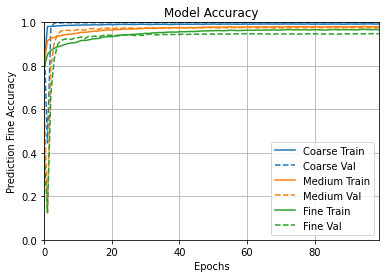

In [17]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

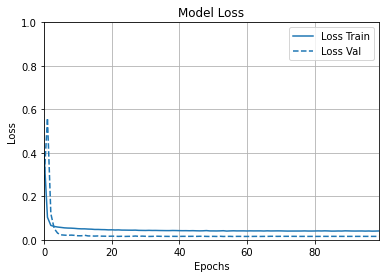

In [18]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 6s 14ms/step - loss: 0.0250 - prediction_coarse_loss: 0.0013 - prediction_medium_loss: 0.0188 - prediction_fine_loss: 0.0415 - prediction_coarse_accuracy: 0.9989 - prediction_medium_accuracy: 0.9753 - prediction_fine_accuracy: 0.9475
1. loss ==> 0.025035960599780083
2. prediction_coarse_loss ==> 0.0012700064107775688
3. prediction_medium_loss ==> 0.018772736191749573
4. prediction_fine_loss ==> 0.04145636409521103
5. prediction_coarse_accuracy ==> 0.9988999962806702
6. prediction_medium_accuracy ==> 0.9753000140190125
7. prediction_fine_accuracy ==> 0.9474999904632568
313/313 [==============================] - 4s 9ms/step


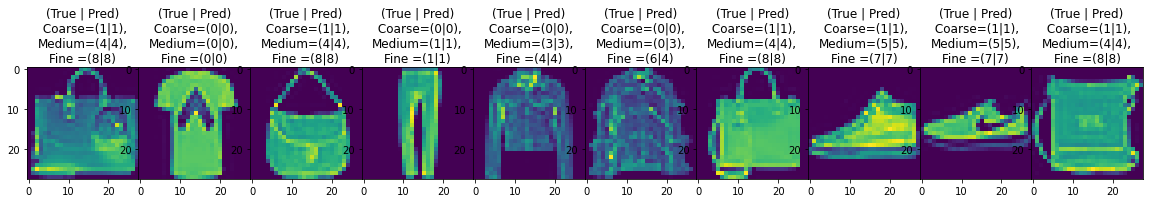

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[5993    7]
 [   4 3996]]

  • MEDIUM LEVEL 
[[2908    1   32   53    6    0]
 [   1  990    8    0    1    0]
 [  51    1  934   14    0    0]
 [  64    0    9  927    0    0]
 [   2    0    1    1  995    1]
 [   1    0    0    0    0 2999]]

  • FINE LEVEL 
[[894   1  19  10   0   0  72   0   4   0]
 [  1 990   0   8   0   0   0   0   1   0]
 [ 12   1 923   8  20   0  36   0   0   0]
 [ 14   1   8 937  14   0  26   0   0   0]
 [  2   0  25   8 930   0  35   0   0   0]
 [  0   0   0   0   0 991   0   8   0   1]
 [ 67   0  20  15  33   0 862   0   3   0]
 [  0   0   0   0   0   1   0 985   0  14]
 [  2   0   0   1   1   1   1   0 994   0]
 [  0   0   1   0   0   5   0  25   0 969]]

  • Classification Report 


  • COARSE LEVEL 


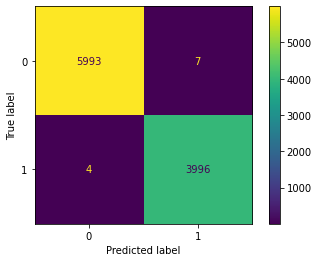

              precision    recall  f1-score   support

           0    0.99933   0.99883   0.99908      6000
           1    0.99825   0.99900   0.99863      4000

    accuracy                        0.99890     10000
   macro avg    0.99879   0.99892   0.99885     10000
weighted avg    0.99890   0.99890   0.99890     10000


  • MEDIUM LEVEL 


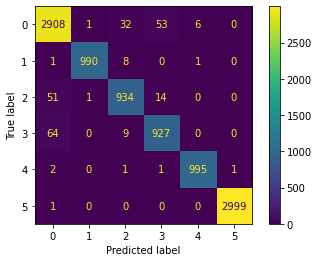

              precision    recall  f1-score   support

           0    0.96069   0.96933   0.96499      3000
           1    0.99798   0.99000   0.99398      1000
           2    0.94919   0.93400   0.94153      1000
           3    0.93166   0.92700   0.92932      1000
           4    0.99301   0.99500   0.99401      1000
           5    0.99967   0.99967   0.99967      3000

    accuracy                        0.97530     10000
   macro avg    0.97203   0.96917   0.97058     10000
weighted avg    0.97529   0.97530   0.97528     10000


  • FINE LEVEL 


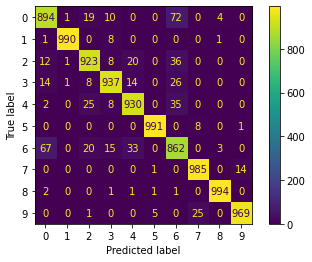

              precision    recall  f1-score   support

           0    0.90121   0.89400   0.89759      1000
           1    0.99698   0.99000   0.99348      1000
           2    0.92671   0.92300   0.92485      1000
           3    0.94934   0.93700   0.94313      1000
           4    0.93186   0.93000   0.93093      1000
           5    0.99299   0.99100   0.99199      1000
           6    0.83527   0.86200   0.84843      1000
           7    0.96758   0.98500   0.97621      1000
           8    0.99202   0.99400   0.99301      1000
           9    0.98476   0.96900   0.97681      1000

    accuracy                        0.94750     10000
   macro avg    0.94787   0.94750   0.94764     10000
weighted avg    0.94787   0.94750   0.94764     10000



In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9738466666666667 
Hierarchical Recall = 0.9741333333333334 
Hierarchical F1-Score = 0.9739666666666666 
Consistency =  0.9987 
Exact Match =  0.9468
